In [2]:
import numpy as np
import pandas as pd

weather_df = pd.read_csv('../data/weatherHistory.csv')
weather_df.head(5)


Formatted Date        Summary Precip Type  Temperature (C)  \
0  2006-04-01 00:00:00.000 +0200  Partly Cloudy        rain         9.472222   
1  2006-04-01 01:00:00.000 +0200  Partly Cloudy        rain         9.355556   
2  2006-04-01 02:00:00.000 +0200  Mostly Cloudy        rain         9.377778   
3  2006-04-01 03:00:00.000 +0200  Partly Cloudy        rain         8.288889   
4  2006-04-01 04:00:00.000 +0200  Mostly Cloudy        rain         8.755556   

   Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0                  7.388889      0.89            14.1197   
1                  7.227778      0.86            14.2646   
2                  9.377778      0.89             3.9284   
3                  5.944444      0.83            14.1036   
4                  6.977778      0.83            11.0446   

   Wind Bearing (degrees)  Visibility (km)  Loud Cover  Pressure (millibars)  \
0                   251.0          15.8263         0.0               1015.13   
1                   259.0          15.8263         0.0               1015.63   
2                   204.0          14.9569         0.0               1015.94   
3                   269.0          15.8263         0.0               1016.41   
4                   259.0          15.8263         0.0               1016.51   

                       Daily Summary  
0  Partly cloudy throughout the day.  
1  Partly cloudy throughout the day.  
2  Partly cloudy throughout the day.  
3  Partly cloudy throughout the day.  
4  Partly cloudy throughout the day.

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

px.histogram(weather_df, x='Temperature (C)', color='Precip Type')

<Axes: xlabel='Temperature (C)', ylabel='Count'>

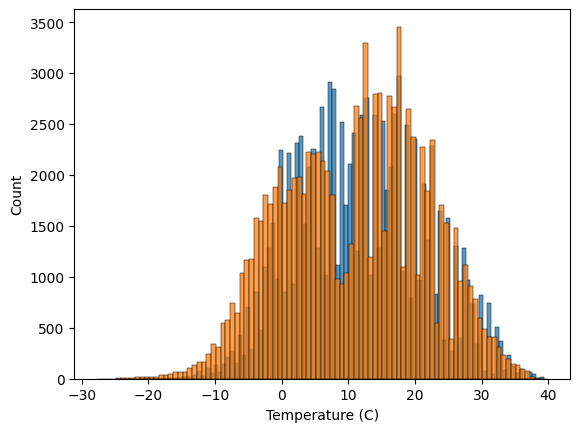

In [42]:
sns.histplot(weather_df, x='Temperature (C)')
sns.histplot(weather_df, x='Apparent Temperature (C)')

In [13]:
px.histogram(weather_df, x='Temperature (C)', y='Wind Speed (km/h)',
              marginal='box', 
              title='Wind Speed vs Temperature')

## Data Cleaning

In [28]:
weather_df["Formatted Date"] = pd.to_datetime(weather_df["Formatted Date"], utc=True).dt.tz_convert(None)
year = weather_df["Formatted Date"].dt.year

train_df = weather_df[year < 2014]
val_df = weather_df[year == 2014]
test_df = weather_df[year > 2014]


print(train_df.shape, val_df.shape, test_df.shape)

(70153, 13) (8757, 13) (17543, 13)


In [30]:
target_col = "Temperature (C)"

input_cols = [col for col in list(train_df.columns)[1:] if col != target_col]
input_cols


['Summary',
 'Precip Type',
 'Apparent Temperature (C)',
 'Humidity',
 'Wind Speed (km/h)',
 'Wind Bearing (degrees)',
 'Visibility (km)',
 'Loud Cover',
 'Pressure (millibars)',
 'Daily Summary',
 'Year']

In [43]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

In [45]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Formatted Date            96453 non-null  datetime64[ns]
 1   Summary                   96453 non-null  object        
 2   Precip Type               95936 non-null  object        
 3   Temperature (C)           96453 non-null  float64       
 4   Apparent Temperature (C)  96453 non-null  float64       
 5   Humidity                  96453 non-null  float64       
 6   Wind Speed (km/h)         96453 non-null  float64       
 7   Wind Bearing (degrees)    96453 non-null  float64       
 8   Visibility (km)           96453 non-null  float64       
 9   Loud Cover                96453 non-null  float64       
 10  Pressure (millibars)      96453 non-null  float64       
 11  Daily Summary             96453 non-null  object        
 12  Year              

In [44]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [46]:
train_inputs[categorical_cols].nunique()


Summary           26
Precip Type        2
Daily Summary    185
dtype: int64

In [48]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
weather_df[numeric_cols].isna().sum()
imputer.fit(weather_df[numeric_cols])

SimpleImputer()

In [49]:
list(imputer.statistics_)

[np.float64(10.855028874166692),
 np.float64(0.7348989663359357),
 np.float64(10.810640140793963),
 np.float64(187.50923247592092),
 np.float64(10.347324929240148),
 np.float64(0.0),
 np.float64(1003.2359558541466),
 np.float64(2011.0002902968286)]

In [50]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

In [51]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(train_inputs[numeric_cols])

MinMaxScaler()

In [52]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [53]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

raw_df2 = weather_df[categorical_cols].fillna('Unknown')

encoder.fit(raw_df2)
encoder.categories_

[array(['Breezy', 'Breezy and Dry', 'Breezy and Foggy',
        'Breezy and Mostly Cloudy', 'Breezy and Overcast',
        'Breezy and Partly Cloudy', 'Clear',
        'Dangerously Windy and Partly Cloudy', 'Drizzle', 'Dry',
        'Dry and Mostly Cloudy', 'Dry and Partly Cloudy', 'Foggy',
        'Humid and Mostly Cloudy', 'Humid and Overcast',
        'Humid and Partly Cloudy', 'Light Rain', 'Mostly Cloudy',
        'Overcast', 'Partly Cloudy', 'Rain', 'Windy', 'Windy and Dry',
        'Windy and Foggy', 'Windy and Mostly Cloudy', 'Windy and Overcast',
        'Windy and Partly Cloudy'], dtype=object),
 array(['Unknown', 'rain', 'snow'], dtype=object),
 array(['Breezy and foggy starting in the evening.',
        'Breezy and foggy until morning.',
        'Breezy and mostly cloudy overnight.',
        'Breezy and partly cloudy in the afternoon.',
        'Breezy in the morning and foggy in the evening.',
        'Breezy in the morning and mostly cloudy starting in the evening.',
    

In [54]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
encoded_cols

['Summary_Breezy',
 'Summary_Breezy and Dry',
 'Summary_Breezy and Foggy',
 'Summary_Breezy and Mostly Cloudy',
 'Summary_Breezy and Overcast',
 'Summary_Breezy and Partly Cloudy',
 'Summary_Clear',
 'Summary_Dangerously Windy and Partly Cloudy',
 'Summary_Drizzle',
 'Summary_Dry',
 'Summary_Dry and Mostly Cloudy',
 'Summary_Dry and Partly Cloudy',
 'Summary_Foggy',
 'Summary_Humid and Mostly Cloudy',
 'Summary_Humid and Overcast',
 'Summary_Humid and Partly Cloudy',
 'Summary_Light Rain',
 'Summary_Mostly Cloudy',
 'Summary_Overcast',
 'Summary_Partly Cloudy',
 'Summary_Rain',
 'Summary_Windy',
 'Summary_Windy and Dry',
 'Summary_Windy and Foggy',
 'Summary_Windy and Mostly Cloudy',
 'Summary_Windy and Overcast',
 'Summary_Windy and Partly Cloudy',
 'Precip Type_Unknown',
 'Precip Type_rain',
 'Precip Type_snow',
 'Daily Summary_Breezy and foggy starting in the evening.',
 'Daily Summary_Breezy and foggy until morning.',
 'Daily Summary_Breezy and mostly cloudy overnight.',
 'Daily Su

In [55]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols].fillna('Unknown'))
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols].fillna('Unknown'))
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols].fillna('Unknown'))

C:\Users\DILSHOD\AppData\Local\Temp\ipykernel_6848\3395297854.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\DILSHOD\AppData\Local\Temp\ipykernel_6848\3395297854.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\DILSHOD\AppData\Local\Temp\ipykernel_6848\3395297854.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragment

In [56]:
pd.set_option('display.max_columns', None)

In [57]:
test_inputs


Summary Precip Type  Apparent Temperature (C)  Humidity  \
78909             Overcast        rain                  0.577583      0.71   
78910  Breezy and Overcast        rain                  0.577251      0.62   
78911             Overcast        rain                  0.517936      0.64   
78912             Overcast        rain                  0.511142      0.67   
78913             Overcast        rain                  0.496893      0.67   
...                    ...         ...                       ...       ...   
96448        Partly Cloudy        rain                  0.801259      0.43   
96449        Partly Cloudy        rain                  0.779886      0.48   
96450        Partly Cloudy        rain                  0.741944      0.56   
96451        Partly Cloudy        rain                  0.734239      0.60   
96452        Partly Cloudy        rain                  0.718085      0.61   

       Wind Speed (km/h)  Wind Bearing (degrees)  Visibility (km)  Loud Cover  \
78909           0.390318                0.860724            0.637         0.0   
78910           0.487897                0.835655            0.637         0.0   
78911           0.349218                0.860724            0.894         0.0   
78912           0.227181                0.863510            0.943         0.0   
78913           0.264498                0.807799            0.943         0.0   
...                  ...                     ...              ...         ...   
96448           0.172214                0.086351            1.000         0.0   
96449           0.158094                0.055710            0.966         0.0   
96450           0.140696                0.083565            1.000         0.0   
96451           0.164902                0.055710            1.000         0.0   
96452           0.092032                0.108635            0.964         0.0   

       Pressure (millibars)  \
78909              0.960034   
78910              0.960722   
78911              0.961677   
78912              0.961735   
78913              0.962987   
...                     ...   
96448              0.969399   
96449              0.970164   
96450              0.970642   
96451              0.970919   
96452              0.971119   

                                           Daily Summary   Year  \
78909  Mostly cloudy throughout the day and breezy in...  1.250   
78910  Mostly cloudy throughout the day and breezy in...  1.250   
78911  Mostly cloudy throughout the day and breezy in...  1.250   
78912  Mostly cloudy throughout the day and breezy in...  1.250   
78913  Mostly cloudy throughout the day and breezy in...  1.250   
...                                                  ...    ...   
96448             Partly cloudy starting in the morning.  1.375   
96449             Partly cloudy starting in the morning.  1.375   
96450             Partly cloudy starting in the morning.  1.375   
96451             Partly cloudy starting in the morning.  1.375   
96452             Partly cloudy starting in the morning.  1.375   

       Summary_Breezy  Summary_Breezy and Dry  Summary_Breezy and Foggy  \
78909             0.0                     0.0                       0.0   
78910             0.0                     0.0                       0.0   
78911             0.0                     0.0                       0.0   
78912             0.0                     0.0                       0.0   
78913             0.0                     0.0                       0.0   
...               ...                     ...                       ...   
96448             0.0                     0.0                       0.0   
96449             0.0                     0.0                       0.0   
96450             0.0                     0.0                       0.0   
96451             0.0                     0.0                       0.0   
96452             0.0                     0.0                       0.0   

       Summary_Breezy and Most

In [58]:
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)
print('test_inputs:', test_inputs.shape)
print('test_targets:', test_targets.shape)

train_inputs: (70153, 255)
train_targets: (70153,)
val_inputs: (8757, 255)
val_targets: (8757,)
test_inputs: (17543, 255)
test_targets: (17543,)


In [59]:
train_inputs.to_csv('../data/linearRegression/train_inputs.csv')
val_inputs.to_csv('../data/linearRegression/val_inputs.csv')
test_inputs.to_csv('../data/linearRegression/test_inputs.csv')

In [60]:
pd.DataFrame(train_targets).to_csv('../data/linearRegression/train_targets.csv')
pd.DataFrame(val_targets).to_csv('../data/linearRegression/val_targets.csv')
pd.DataFrame(test_targets).to_csv('../data/linearRegression/test_targets.csv')

## Training Model

In [61]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(train_inputs[numeric_cols+encoded_cols], train_targets)


LinearRegression()

In [62]:
pd.DataFrame({
    'features': numeric_cols + encoded_cols,
    'weight': model.coef_.tolist()[0]
}).to_csv('../data/linearRegression/results/weights.csv')

In [67]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]


train_preds = model.predict(X_train)
train_preds

array([ 8.92591554,  8.83547424,  9.6933551 , ..., 14.15577113,
       12.72680374, -0.56603636], shape=(70153,))

In [74]:
from sklearn.metrics import r2_score

r2_train = r2_score(train_targets, train_preds)

print("Train R²:", r2_train)

Train R²: 0.9910386443757275


In [79]:
new_input_df = pd.DataFrame([{
    "Year": "2006",
    "Summary": "Overcast",
    "Precip Type": "rain",
    "Apparent Temperature (C)": 10.5,
    "Humidity": 0.82,
    "Wind Speed (km/h)": 12.0,
    "Wind Bearing (degrees)": 240.0,
    "Visibility (km)": 16.0,
    "Loud Cover": 0.0,
    "Pressure (millibars)": 1012.5,
    "Daily Summary": "Overcast throughout the day."
}])


new_input_df[numeric_cols] = imputer.transform(new_input_df[numeric_cols])
new_input_df[numeric_cols] = scaler.transform(new_input_df[numeric_cols])
new_input_df[encoded_cols] = encoder.transform(new_input_df[categorical_cols])

C:\Users\DILSHOD\AppData\Local\Temp\ipykernel_6848\3168433364.py:18: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\DILSHOD\AppData\Local\Temp\ipykernel_6848\3168433364.py:18: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\DILSHOD\AppData\Local\Temp\ipykernel_6848\3168433364.py:18: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragm

In [80]:
X_new_input = new_input_df[numeric_cols + encoded_cols]
X_new_input

Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0                  0.569878      0.82           0.187933   

   Wind Bearing (degrees)  Visibility (km)  Loud Cover  Pressure (millibars)  \
0                0.668524         0.993789         0.0              0.967622   

    Year  Summary_Breezy  Summary_Breezy and Dry  Summary_Breezy and Foggy  \
0  0.125             0.0                     0.0                       0.0   

   Summary_Breezy and Mostly Cloudy  Summary_Breezy and Overcast  \
0                               0.0                          0.0   

   Summary_Breezy and Partly Cloudy  Summary_Clear  \
0                               0.0            0.0   

   Summary_Dangerously Windy and Partly Cloudy  Summary_Drizzle  Summary_Dry  \
0                                          0.0              0.0          0.0   

   Summary_Dry and Mostly Cloudy  Summary_Dry and Partly Cloudy  \
0                            0.0                            0.0   

   Summary_Foggy  Summary_Humid and Mostly Cloudy  Summary_Humid and Overcast  \
0            0.0                              0.0                         0.0   

   Summary_Humid and Partly Cloudy  Summary_Light Rain  Summary_Mostly Cloudy  \
0                              0.0                 0.0                    0.0   

   Summary_Overcast  Summary_Partly Cloudy  Summary_Rain  Summary_Windy  \
0               1.0                    0.0           0.0            0.0   

   Summary_Windy and Dry  Summary_Windy and Foggy  \
0                    0.0                      0.0   

   Summary_Windy and Mostly Cloudy  Summary_Windy and Overcast  \
0                              0.0                         0.0   

   Summary_Windy and Partly Cloudy  Precip Type_Unknown  Precip Type_rain  \
0                              0.0                  0.0               1.0   

   Precip Type_snow  Daily Summary_Breezy and foggy starting in the evening.  \
0               0.0                                                0.0         

   Daily Summary_Breezy and foggy until morning.  \
0                                            0.0   

   Daily Summary_Breezy and mostly cloudy overnight.  \
0                                                0.0   

   Daily Summary_Breezy and partly cloudy in the afternoon.  \
0                                                0.0          

   Daily Summary_Breezy in the morning and foggy in the evening.  \
0                                                0.0               

   Daily Summary_Breezy in the morning and mostly cloudy starting in the evening.  \
0                                                0.0                                

   Daily Summary_Breezy in the morning and mostly cloudy starting in the morning.  \
0                                                0.0                                

   Daily Summary_Breezy in the morning and partly cloudy starting in the evening continuing until night.  \
0                                                0.0                                                       

   Daily Summary_Breezy overnight and mostly cloudy throughout the day.  \
0                                                0.0                      

   Daily Summary_Breezy overnight and overcast throughout the day.  \
0                                                0.0                 

   Daily Summary_Breezy overnight and partly cloudy throughout the day.  \
0                                                0.0                      

   Daily Summary_Breezy overnight and partly cloudy until evening.  \
0                                                0.0                 

   Daily Summary_Breezy starting in the afternoon continuing until evening and foggy in the evening.  \
0                                                0.0                                                   

   Daily Summary_Breezy starting in the afternoon continuing until evening and foggy starting in the evening.  \
0                                         

In [81]:
prediction = model.predict(X_new_input)[0]

In [82]:
prediction


np.float64(11.533690409202833)